In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from math import comb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import random
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CosineAnnealingLR
from scipy.interpolate import splprep, splev

## VAE + mesh

In [43]:
def find_min_max(col):
    """Finds the minimum and maximum y-indices where pixel values are 0 (black) in a column.
    Args:
        col (numpy.ndarray): Single column of image data
    Returns:
        tuple: (y_min, y_max) coordinates of first and last black pixels
    """
    zero_indices = np.argwhere(col == 0)
    
    y_min = int(np.min(zero_indices))
    y_max = int(np.max(zero_indices))
    
    return y_min, y_max

In [44]:
def normalize_contour(contour, n_points=100):
    contour = contour.squeeze()
    #closed_contour = np.vstack([contour, contour[0]])
    
    try:
        tck, _ = splprep(contour.T, s=0, per=True) #closed_contour
        new_points = splev(np.linspace(0, 1, n_points), tck)
        return np.column_stack(new_points)
    except:
        return np.column_stack([
            np.linspace(contour[0,0], contour[-1,0], n_points),
            np.linspace(contour[0,1], contour[-1,1], n_points)
        ])

In [45]:
def load_and_preprocess_data(folder_path, target_points=100):
    
    images = []
    img = cv2.imread(os.path.join(folder_path, 'idx_1_1_50.png'), cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    inverted = cv2.bitwise_not(binary)
    images.append(inverted)
    
    for filename in os.listdir(folder_path):
        if (filename.endswith('.png')) & (filename != 'idx_1_1_50.png'):
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
            inverted = cv2.bitwise_not(binary)
            images.append(inverted)
    
    H = max(Image.open(os.path.join(folder_path, f)).size[1] for f in os.listdir(folder_path) if f.endswith(".png"))
    W = min(Image.open(os.path.join(folder_path, f)).size[0] for f in os.listdir(folder_path) if f.endswith(".png"))
    plt.imshow(images[-1], cmap = 'gray')
    contours = []
    for k,img in enumerate(images):

        inverted = cv2.bitwise_not(img)
        cnt, _ = cv2.findContours(inverted, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if len(cnt) == 0:
            continue
        
        contours.append(normalize_contour(np.array(cnt), n_points=target_points))
        print(f'Preprocess {k} image')

    print('Preprocessing done!')
    #plt.imshow(img_w)
    
    return np.array(contours)

In [46]:
def normalize_features(features, scale_factor=1.0):
    max_deformation = np.max(np.abs(features))
    normalized = features / (max_deformation + 1e-8) * scale_factor
    return normalized, max_deformation

In [47]:
def create_rimd_features(contours):
    reference = contours[0]
    features = []
    for contour in contours:
        deformation = contour - reference
        features.append(deformation.flatten())
    features, max_deformation = normalize_features(features)
    return np.array(features), reference, max_deformation

In [48]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=128):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        
    
        self.encoder_fc1 = nn.Linear(input_dim, 128)
        self.encoder_fc2 = nn.Linear(128, 1024)
        self.encoder_fc3 = nn.Linear(1024, latent_dim * 2)  # mean and logvar
        
        
        self.decoder_fc1 = nn.Linear(latent_dim, 1024)
        self.decoder_fc2 = nn.Linear(1024, 128)
        self.decoder_fc3 = nn.Linear(128, input_dim)
        
        self.relu = nn.ReLU()
    
    def encoder(self, x):
        h = self.relu(self.encoder_fc2(self.relu(self.encoder_fc1(x))))
        return self.encoder_fc3(h)  
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decoder(self, z):
        h = self.relu(self.decoder_fc2(self.relu(self.decoder_fc1(z))))
        return self.decoder_fc3(h)
    
    def forward(self, x):
        encoded = self.encoder(x)
        mu, logvar = encoded[:, :self.latent_dim], encoded[:, self.latent_dim:]
        z = self.reparameterize(mu, logvar)
        
    
        reconstruction = self.decoder(z)
        return reconstruction, mu, logvar

In [49]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [50]:
def train_model(features, test_size=0.2, epochs=100, batch_size=32):

    X_train, X_test = train_test_split(features, test_size=test_size, random_state=42)
    
    train_tensor = torch.FloatTensor(X_train)
    test_tensor = torch.FloatTensor(X_test)
    
    train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
    
    input_dim = features.shape[1]
    model = VAE(input_dim)
    #optimizer = optim.Adam(model.parameters(), lr=0.0001)
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, data in enumerate(train_loader):
            data = data[0]
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = vae_loss(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            recon_test, mu_test, logvar_test = model(test_tensor)
            test_loss = vae_loss(recon_test, test_tensor, mu_test, logvar_test).item()
        
        train_losses.append(train_loss / len(train_loader.dataset))
        test_losses.append(test_loss / len(test_tensor))

        scheduler.step()
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')
    
    return model, train_losses, test_losses

In [51]:
def plot_results(model, reference, contours, features, max_deformation, n_samples=5):
    model.eval()
    with torch.no_grad():
        idx = np.random.choice(len(contours), n_samples)
        sample_features = torch.FloatTensor(features[idx])
        
        reconstructions, _, _ = model(sample_features)
        reconstructions = reconstructions.numpy().reshape(-1, 100, 2)
        
        plt.figure(figsize=(15, 3))
        for i in range(n_samples):
            reconstructed = reference + reconstructions[i]*max_deformation
            original = contours[idx[i]]
            
            plt.subplot(1, n_samples, i+1)
            plt.plot(reference[:,0], reference[:,1], 'k--', linewidth=1, alpha=0.5)
            plt.plot(original[:,0], original[:,1], 'b-', label='Original')
            plt.plot(reconstructed[:,0], reconstructed[:,1], 'r--', label='Reconstructed')
            plt.axis('equal')
            plt.legend()
        plt.show()

In [52]:
def plot_interpolation(model, reference, features, max_deformation, idx1=0, idx2=1):
    model.eval()
    with torch.no_grad():
        encoded = model.encoder(torch.FloatTensor(features[idx1:idx1+1]))
        mu1, logvar1 = encoded[:, :model.latent_dim], encoded[:, model.latent_dim:]
        z1 = model.reparameterize(mu1, logvar1)
        
        encoded = model.encoder(torch.FloatTensor(features[idx2:idx2+1]))
        mu2, logvar2 = encoded[:, :model.latent_dim], encoded[:, model.latent_dim:]
        z2 = model.reparameterize(mu2, logvar2)
        

        plt.figure(figsize=(12, 6))
        for i, t in enumerate(np.linspace(0, 1, 8)):
            z = z1 * (1 - t) + z2 * t
            reconstruction = model.decoder(z).numpy().reshape(-1, 100, 2)
            interpolated = reference + reconstruction[0]*max_deformation 
            
            plt.subplot(2, 4, i+1)
            plt.plot(interpolated[:,0], interpolated[:,1], 'k-')
            plt.axis('equal')
            plt.title(f"t={t:.1f}")
        plt.show()

Preprocess 0 image
Preprocess 1 image
Preprocess 2 image
Preprocess 3 image
Preprocess 4 image
Preprocess 5 image
Preprocess 6 image
Preprocess 7 image
Preprocess 8 image
Preprocess 9 image
Preprocess 10 image
Preprocess 11 image
Preprocess 12 image
Preprocess 13 image
Preprocess 14 image
Preprocess 15 image
Preprocess 16 image
Preprocess 17 image
Preprocess 18 image
Preprocess 19 image
Preprocess 20 image
Preprocess 21 image
Preprocess 22 image
Preprocess 23 image
Preprocess 24 image
Preprocess 25 image
Preprocess 26 image
Preprocess 27 image
Preprocess 28 image
Preprocess 29 image
Preprocess 30 image
Preprocess 31 image
Preprocess 32 image
Preprocess 33 image
Preprocess 34 image
Preprocess 35 image
Preprocess 36 image
Preprocess 37 image
Preprocess 38 image
Preprocess 39 image
Preprocess 40 image
Preprocess 41 image
Preprocess 42 image
Preprocess 43 image
Preprocess 44 image
Preprocess 45 image
Preprocess 46 image
Preprocess 47 image
Preprocess 48 image
Preprocess 49 image
Preprocess

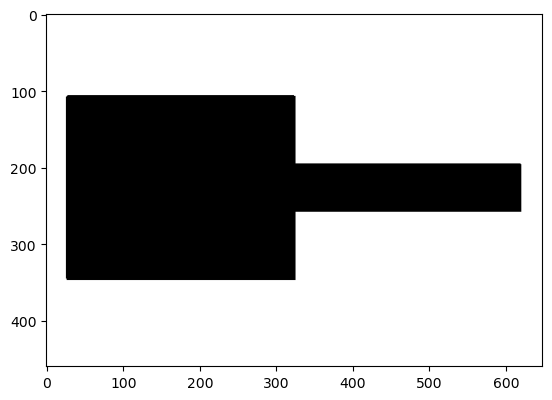

In [53]:
folder_path = "dataset"
contours = load_and_preprocess_data(folder_path)

(100, 2)


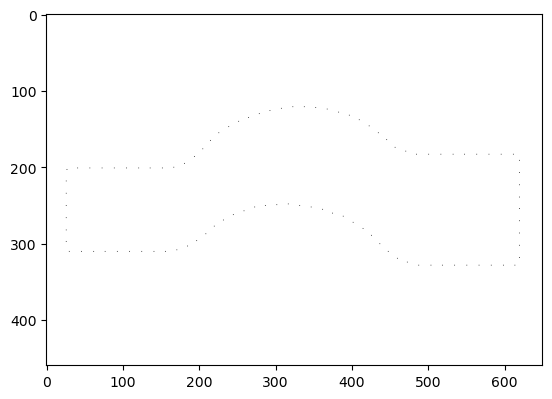

In [54]:
sample_contour = contours[3]
print(sample_contour.shape)

contour_image = 255*np.ones((460,650))

for x,y in sample_contour:
    contour_image[round(y),round(x)] = 0
plt.imshow(contour_image, cmap='gray')

Min after normalization: -0.9652362991493123
Max after normalization: 0.999999999982699
Mean: 0.002432604360197724


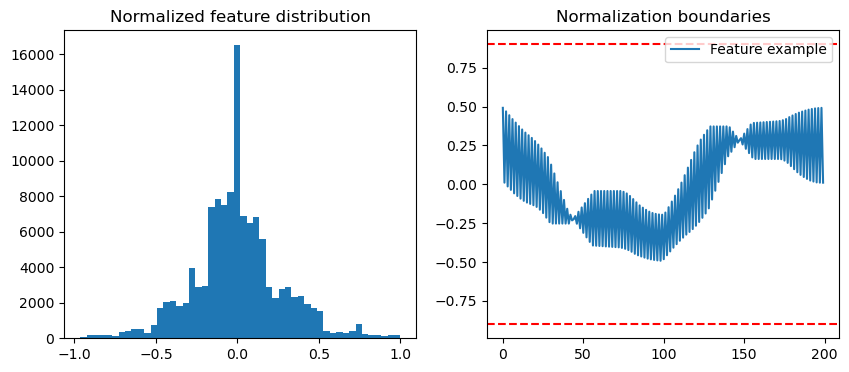

In [55]:
features, reference, max_deformation = create_rimd_features(contours)

print("Min after normalization:", np.min(features))
print("Max after normalization:", np.max(features))
print("Mean:", np.mean(features))

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.hist(features.flatten(), bins=50)
plt.title("Normalized feature distribution")

plt.subplot(122)
plt.plot(features[1], label='Feature example')
plt.axhline(y=-0.9, color='r', linestyle='--')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title("Normalization boundaries")
plt.legend()
plt.show()

In [56]:
max_deformation

578.0000000000002

In [58]:
model, train_loss, test_loss = train_model(features, epochs=1000)
os.makedirs('models_vae', exist_ok=True)
torch.save(model.state_dict(), f"models_vae/best_val_vae.pth")

Epoch 1/1000, Train Loss: 11.3183, Test Loss: 7.3571
Epoch 2/1000, Train Loss: 6.8112, Test Loss: 5.6493
Epoch 3/1000, Train Loss: 5.0265, Test Loss: 5.0837
Epoch 4/1000, Train Loss: 4.7757, Test Loss: 4.5912
Epoch 5/1000, Train Loss: 4.6201, Test Loss: 4.6084
Epoch 6/1000, Train Loss: 4.7616, Test Loss: 4.4819
Epoch 7/1000, Train Loss: 4.3504, Test Loss: 4.3392
Epoch 8/1000, Train Loss: 4.4387, Test Loss: 4.3833
Epoch 9/1000, Train Loss: 4.4386, Test Loss: 4.0054
Epoch 10/1000, Train Loss: 4.3923, Test Loss: 4.3730
Epoch 11/1000, Train Loss: 4.2364, Test Loss: 4.0987
Epoch 12/1000, Train Loss: 4.2700, Test Loss: 4.4720
Epoch 13/1000, Train Loss: 4.2376, Test Loss: 4.6999
Epoch 14/1000, Train Loss: 4.3860, Test Loss: 4.0606
Epoch 15/1000, Train Loss: 4.1757, Test Loss: 4.0216
Epoch 16/1000, Train Loss: 4.4190, Test Loss: 4.2118
Epoch 17/1000, Train Loss: 4.1516, Test Loss: 4.0731
Epoch 18/1000, Train Loss: 4.0425, Test Loss: 4.0098
Epoch 19/1000, Train Loss: 4.1438, Test Loss: 4.3119
E

[[ 1.00046     0.09834461]
 [ 0.98050326  0.07130811]
 [ 0.9552638   0.04018537]
 [ 0.936343    0.01587325]
 [ 0.9039085  -0.01409377]
 [ 0.89081764 -0.03946632]
 [ 0.8637487  -0.06776251]
 [ 0.834553   -0.09925092]
 [ 0.81062585 -0.12603027]
 [ 0.78896016 -0.15350457]
 [ 0.7633847  -0.18151334]
 [ 0.74226385 -0.2103641 ]
 [ 0.7054198  -0.23367237]
 [ 0.69548285 -0.26296994]
 [ 0.6625859  -0.28988516]
 [ 0.62020504 -0.29687408]
 [ 0.56433535 -0.29790223]
 [ 0.518827   -0.29198238]
 [ 0.45967248 -0.29273805]
 [ 0.41328117 -0.29038578]
 [ 0.36200613 -0.2874711 ]
 [ 0.31744933 -0.2824668 ]
 [ 0.25870794 -0.28539714]
 [ 0.20102656 -0.28223765]
 [ 0.15142524 -0.28097236]
 [ 0.09550086 -0.27961436]
 [ 0.04167568 -0.28234252]
 [-0.01929194 -0.27490777]
 [-0.0660964  -0.27803156]
 [-0.1181263  -0.27720982]
 [-0.17788547 -0.27776402]
 [-0.23053265 -0.27449286]
 [-0.28145534 -0.27374402]
 [-0.34407812 -0.27234975]
 [-0.3982616  -0.27499253]
 [-0.44801265 -0.27169192]
 [-0.5030495  -0.26849395]
 

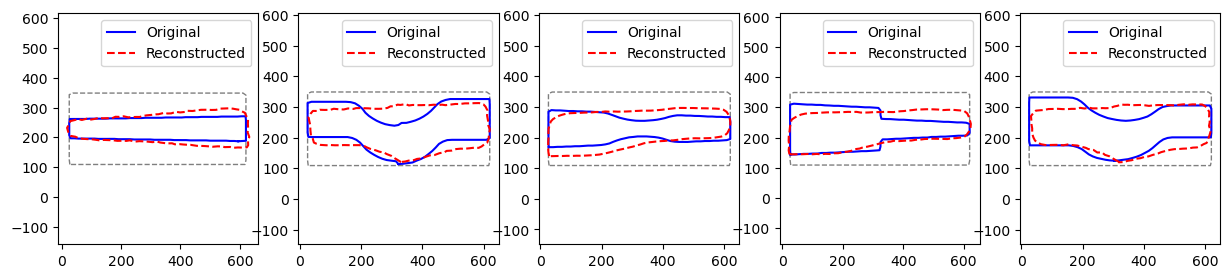

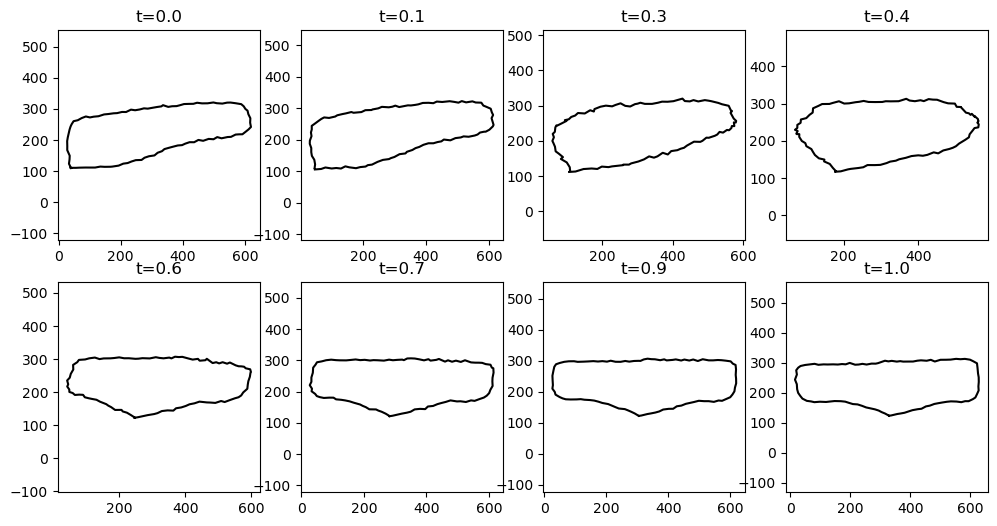

In [ ]:
plot_results(model, reference, contours, features, max_deformation)
plot_interpolation(model, reference, features, max_deformation)

In [60]:
np.max(features)

0.999999999982699

In [61]:
reference

array([[ 28.        , 109.        ],
       [ 26.        , 124.99638958],
       [ 26.        , 141.82120629],
       [ 26.        , 158.646023  ],
       [ 26.        , 175.47083971],
       [ 26.        , 192.29565642],
       [ 26.        , 209.12047313],
       [ 26.        , 225.94528984],
       [ 26.        , 242.77010655],
       [ 26.        , 259.59492326],
       [ 26.        , 276.41973997],
       [ 26.        , 293.24455668],
       [ 26.        , 310.06937339],
       [ 26.        , 326.8941901 ],
       [ 26.00130956, 343.71840123],
       [ 38.12960999, 348.99999997],
       [ 54.95442667, 349.        ],
       [ 71.77924338, 349.        ],
       [ 88.60406009, 349.        ],
       [105.4288768 , 349.        ],
       [122.2536935 , 349.        ],
       [139.07851021, 349.        ],
       [155.90332692, 349.        ],
       [172.72814363, 349.        ],
       [189.55296034, 349.        ],
       [206.37777705, 349.        ],
       [223.20259376, 349.        ],
 

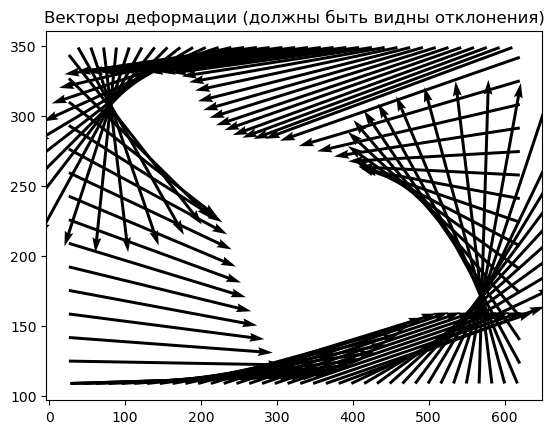

In [64]:
plt.quiver(reference[:,0], reference[:,1], 
           max_deformation*features[2][::2], max_deformation*features[2][1::2], 
           scale=1, scale_units='xy')
plt.title("Векторы деформации (должны быть видны отклонения)")
plt.show()